<a href="https://www.kaggle.com/code/shreyasdomde/weather-detection?scriptVersionId=165412646" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [17]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, callbacks

import warnings
warnings.filterwarnings("ignore")

In [18]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [19]:
datadir = './dataset'

# 😶‍🌫️ Exploring the dataset

In [20]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

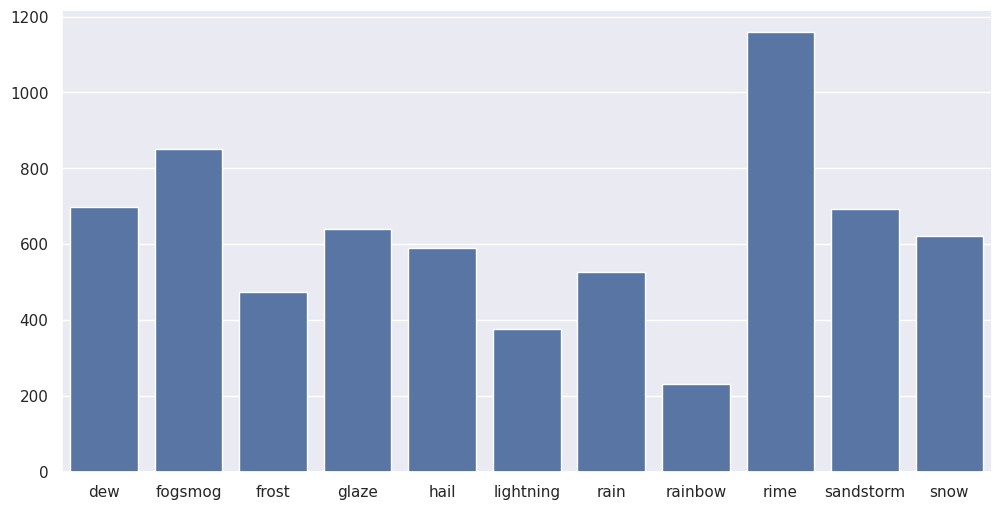

In [21]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

In [ ]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
    
plt.tight_layout()
plt.show()

# ✂️ Splittinng dataset

In [22]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [23]:
df.head()

,filepaths,labels
0,./dataset/dew/2208.jpg,dew
1,./dataset/dew/2209.jpg,dew
2,./dataset/dew/2210.jpg,dew
3,./dataset/dew/2211.jpg,dew
4,./dataset/dew/2212.jpg,dew


# 🎋 Preprocessing Images

In [24]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=44) 

In [25]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [26]:
train_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training'
)

val_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation'
)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.


In [27]:
test_data = train_datagen.flow_from_dataframe(
    df_test, 
    x_col = 'filepaths',
    y_col = 'labels',
    color_mode = 'rgb',
    batch_size = 64
)

Found 1373 validated image filenames belonging to 11 classes.


# 🪸 Training models

### Trial Sequntial model
model = tf.keras.Sequential([
    
    layers.Resizing(150, 150),
    layers.Rescaling(1./255),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=11, activation='softmax'),
])

In [68]:
class Model_builder:
    
    def __init__(self, pretrained_model):
        self.model = self.build_model(pretrained_model)
    
    def build_model(self, pretrained_model):

        for layer in pretrained_model.layers:
            layer.trainable = False

        model = tf.keras.Sequential()
        model.add(layers.Resizing(150, 150))
        model.add(layers.Rescaling(1/255.0))
        model.add(pretrained_model)

        model.add(layers.Flatten())
        model.add(layers.Dense(units=256, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(units=11, activation='softmax'))
        
        return model
    
    def compile_model(self, opt):
        self.model.compile(
            optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )
    
    def model_summary(self):
        self.model.build((None, 150, 150, 3))
        self.model.summary()
        
    def get_model(self):
        return self.model
    

In [70]:
# defining hyperparameters
EPOCHS = 5
early_stop = callbacks.EarlyStopping(
    patience=10,
    monitor='val_loss'
)
reduceLr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor= 0.2,
    patience= 5
)

### 1. VGG16

In [69]:
vgg_pretrained = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_model = Model_builder(vgg_pretrained)
vgg_model.compile_model('adam')
vgg_model.model_summary()
vgg_model = vgg_model.get_model()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 150, 150, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_24 (Ba  (None, 256)              

In [63]:
with tf.device('/device:GPU:0'):
    
    vgg_history = vgg_model.fit(
            train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            batch_size = 64,
            callbacks = [early_stop, reduceLr]
        )

Epoch 1/10
138/138 [==============================] - 76s 553ms/step - loss: 0.9975 - accuracy: 0.6628 - val_loss: 1.0398 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 2/10
138/138 [==============================] - 75s 542ms/step - loss: 0.7941 - accuracy: 0.7345 - val_loss: 0.7946 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 3/10
138/138 [==============================] - 75s 544ms/step - loss: 0.7290 - accuracy: 0.7582 - val_loss: 0.7686 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 4/10
138/138 [==============================] - 75s 541ms/step - loss: 0.6800 - accuracy: 0.7785 - val_loss: 0.7600 - val_accuracy: 0.7493 - lr: 0.0010
Epoch 5/10
138/138 [==============================] - 75s 543ms/step - loss: 0.6621 - accuracy: 0.7855 - val_loss: 0.7722 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 6/10
138/138 [==============================] - 76s 552ms/step - loss: 0.6101 - accuracy: 0.7994 - val_loss: 0.7774 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 7/10
138/138 [==============================] 

### 2. ResNet

In [73]:
resnet_pretrained = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_model = Model_builder(resnet_pretrained)
resnet_model.compile_model('adam')
resnet_model.model_summary()
resnet_model = resnet_model.get_model()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_11 (Resizing)      (None, 150, 150, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_11 (Flatten)        (None, 51200)             0         
                                                                 
 dense_28 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_30 (Ba  (None, 256)             

In [67]:
with tf.device('/device:GPU:0'):
    
    resnet_history = resnet_model.fit(
            train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            batch_size = 64,
            callbacks = [early_stop, reduceLr]
        )

Epoch 1/10
138/138 [==============================] - 81s 553ms/step - loss: 2.1957 - accuracy: 0.2181 - val_loss: 2.1007 - val_accuracy: 0.2926 - lr: 0.0010
Epoch 2/10
138/138 [==============================] - 75s 545ms/step - loss: 2.0401 - accuracy: 0.2694 - val_loss: 2.3294 - val_accuracy: 0.1313 - lr: 0.0010
Epoch 3/10
138/138 [==============================] - 75s 545ms/step - loss: 2.0025 - accuracy: 0.2819 - val_loss: 11.9942 - val_accuracy: 0.0775 - lr: 0.0010
Epoch 4/10
138/138 [==============================] - 75s 547ms/step - loss: 1.9457 - accuracy: 0.2969 - val_loss: 2.4101 - val_accuracy: 0.1048 - lr: 0.0010
Epoch 5/10
138/138 [==============================] - 75s 545ms/step - loss: 1.9528 - accuracy: 0.2974 - val_loss: 2.0699 - val_accuracy: 0.2407 - lr: 0.0010
Epoch 6/10
138/138 [==============================] - 76s 548ms/step - loss: 1.9246 - accuracy: 0.3065 - val_loss: 1.8819 - val_accuracy: 0.2999 - lr: 0.0010
Epoch 7/10
138/138 [==============================]

### 3. Xception

In [71]:
xception_pretrained = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
xception_model = Model_builder(xception_pretrained)
xception_model.compile_model('adam')
xception_model.model_summary()
xception_model = xception_model.get_model()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 150, 150, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_10 (Flatten)        (None, 51200)             0         
                                                                 
 dense_26 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                      

In [72]:
with tf.device('/device:GPU:0'):
    
    xception_history = xception_model.fit(
            train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            batch_size = 64,
            callbacks = [early_stop, reduceLr]
        )

Epoch 1/5
138/138 [==============================] - 81s 555ms/step - loss: 1.0495 - accuracy: 0.6610 - val_loss: 0.7481 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 2/5
138/138 [==============================] - 75s 545ms/step - loss: 0.6621 - accuracy: 0.7769 - val_loss: 0.6305 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 3/5
138/138 [==============================] - 75s 547ms/step - loss: 0.5961 - accuracy: 0.7980 - val_loss: 0.6664 - val_accuracy: 0.7739 - lr: 0.0010
Epoch 4/5
138/138 [==============================] - 75s 545ms/step - loss: 0.5086 - accuracy: 0.8276 - val_loss: 0.5993 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 5/5
138/138 [==============================] - 76s 554ms/step - loss: 0.4909 - accuracy: 0.8263 - val_loss: 0.5965 - val_accuracy: 0.8022 - lr: 0.0010


# Evaluating models

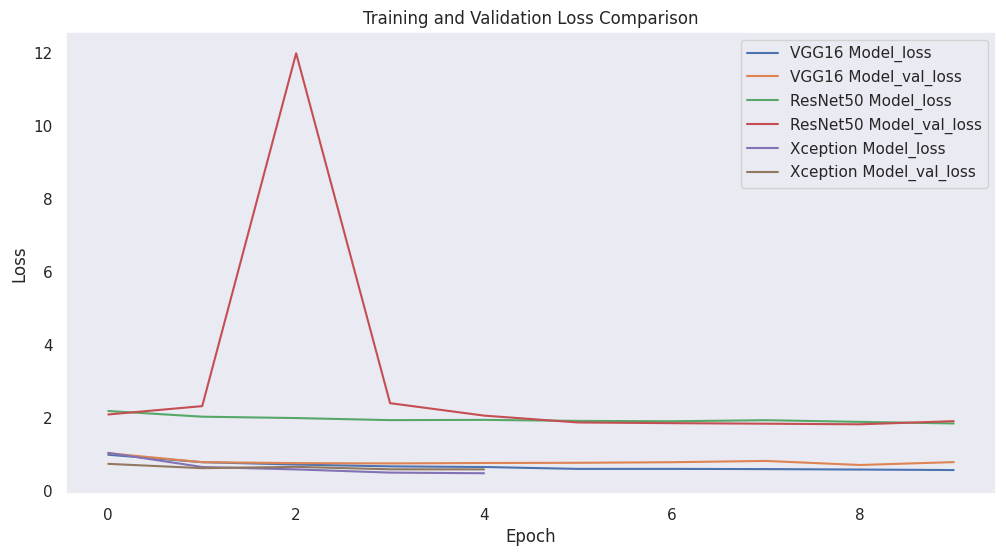

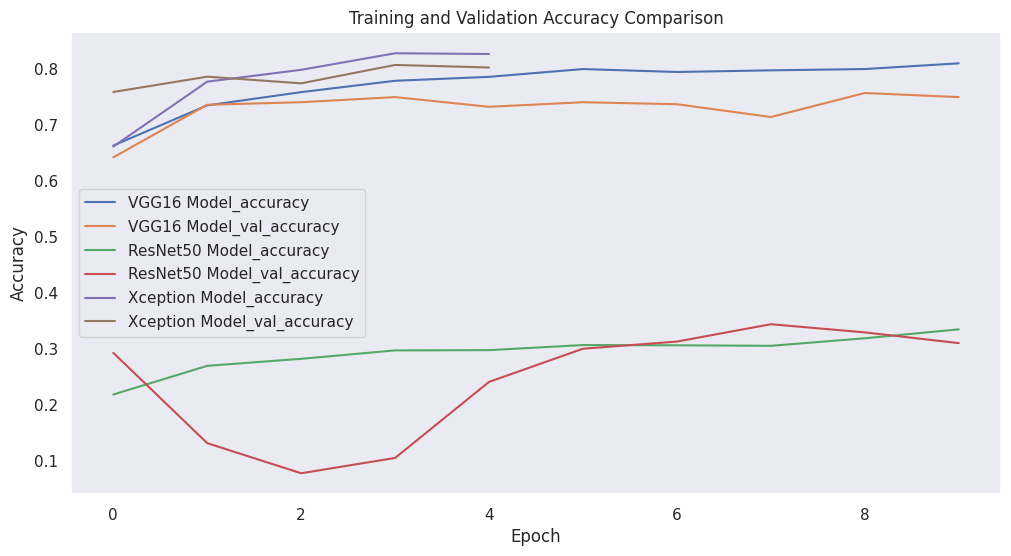

In [78]:
histories = [vgg_history, resnet_history, xception_history]
model_names = ['VGG16 Model', 'ResNet50 Model', 'Xception Model']  # Adjust names as needed

for history, name in zip(histories, model_names):
    plt.plot(history.history['loss'], label=name + '_loss')
    plt.plot(history.history['val_loss'], label=name + '_val_loss')  # If validation loss is available

plt.title('Training and Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# If you have accuracy metrics:
for history, name in zip(histories, model_names):
    plt.plot(history.history['accuracy'], label=name + '_accuracy')
    plt.plot(history.history['val_accuracy'], label=name + '_val_accuracy')  # If available

plt.title('Training and Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


classes = {val:key for key, val in test_data.class_indices.items()}
def vis_pred(ind):
    rows, columns = 3, 4
    x, y = next(iter(train_data))
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(x[ind+i] / 255)
        plt.title(f'Original: {classes[np.argmax(y[ind + i])]} \nPredicted: {classes[np.argmax(y_pred[ind + i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

vis_pred(10)